<a href="https://colab.research.google.com/github/LukaszSzarecki/music-source-separation/blob/develop/ml_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install termtables

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import json
import termtables
import numpy as np
import os
import textwrap
import copy
import matplotlib.pyplot as plt


In [ ]:
!pip install nussl
!pip install git+https://github.com/source-separation/tutorial

import nussl

# Pobranie wyników modeli zapisanych w repozytorium

In [13]:
from pathlib import Path
models_results_branch = Path('/content/models_results_branch').expanduser()  
models_results_branch.mkdir(parents=True, exist_ok=True) 



In [14]:
models_results_branch

PosixPath('/content/models_results_branch')

In [15]:

!git -C /content/models_results_branch clone -b models_results https://github.com/LukaszSzarecki/music-source-separation.git


Cloning into 'music-source-separation'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 77 (delta 15), reused 19 (delta 5), pack-reused 45
Unpacking objects: 100% (77/77), done.


Modele na repozytorium:

In [16]:
import os
from pprint import pprint

model_dir = '/content/models_results_branch/music-source-separation/models_results/'
new_models_results = os.listdir(model_dir + 'new/')
old_models_results = os.listdir(model_dir + 'old/')

pprint("New models results")
for m in new_models_results:
  pprint(m)

pprint("Old trained results")
for m in old_models_results:
  pprint(m)


old_models_results_paths = ["old/" + model_name for model_name in new_models_results]
new_models_results_paths = ["new/" + model_name for model_name in old_models_results]


'New models results'
'vocals.csv'
'bass.csv'
'drums.csv'
'Old trained results'
'vocals.csv'
'bass.csv'
'drums.csv'


# Metody ewaluacji

In [4]:
def _format_title(title, length, marker=" "):
    pad = (length - len(title)) // 2
    pad = ''.join([marker for _ in range(pad)])
    border = pad + title + pad
    if len(title) % 2:
        border = border + marker
    return 

In [5]:
def _get_report_card(df, func, report_each_source=True, decs=2):
    """
    Gets a report card for a DataFrame using a specific function.
    """
    labels, data = func(df, decs=decs)

    data.insert(0, 'OVERALL')
    data = [data]

    if report_each_source:
        for name in np.unique(df['source']):
            _df = df[df['source'] == name]
            _, _data = func(_df, decs=decs)
            _data.insert(0, name.upper())
            data.append(_data)
    

    # transposing data so each column has the source and its metrics
    data = list(map(list, zip(*data)))
    header = data.pop(0)
    header.insert(0, 'METRIC')
    for i in range(1, len(header)):
        header[i] = _format_title(header[i], 16)
    for l, d in zip(labels, data):
        d.insert(0, l)
        
    alignment = ["c" for _ in header]
    alignment[0] = "l"
    alignment = ''.join(alignment)
        
    report_card = termtables.to_string(
        data, header=header, padding=(0, 1), alignment=alignment)

    return report_card, data

In [6]:
def truncate(values, decs=2):
    return np.trunc(values*10**decs)/(10**decs)

In [7]:
def _get_mean(df, decs=2):
    """
    Gets the mean of each metric in the pandas
    DataFrame and returns it as a list of strings.
    """
    excluded_columns = ['source', 'file']

    metrics = [x for x in list(df.columns) if x not in excluded_columns]
    metrics.insert(0, '#')

    means = [
        f'{truncate(m, decs=decs):{4+decs}.{decs}f}' 
        for m in np.array(df.mean()).T
    ]
    # stds = [
    #     f'{truncate(s, decs=decs):{3+decs}.{decs}f}' 
    #     for s in np.array(df.std()).T
    # ]
    # data = [f'{m} +/- {s}' for m, s in zip(means, stds)]
    data = means
    data.insert(0, df.shape[0])

    return metrics, data


In [8]:
def _get_std(df, decs=2):
    """
    Gets the standard deviation of each metric in the pandas
    DataFrame and returns it as a list of strings.
    """
    excluded_columns = ['source', 'file']

    metrics = [x for x in list(df.columns) if x not in excluded_columns]
    metrics.insert(0, '#')

    # means = [
    #     f'{truncate(m, decs=decs):{4+decs}.{decs}f}' 
    #     for m in np.array(df.mean()).T
    # ]
    stds = [
        f'{truncate(s, decs=decs):{3+decs}.{decs}f}' 
        for s in np.array(df.std()).T
    ]
    # data = [f'{m} +/- {s}' for m, s in zip(means, stds)]
    data = stds
    data.insert(0, df.shape[0])

    return metrics, data

In [9]:
def _get_medians(df, decs=2):
    """
    Gets the median of each metric in the pandas
    DataFrame and returns it as a list of strings.
    """
    excluded_columns = ['source', 'file']

    metrics = [x for x in list(df.columns) if x not in excluded_columns]
    metrics.insert(0, '#')

    data = [
        f'{truncate(m, decs=decs):{4+decs}.{decs}f}' 
        for m in np.array(df.median()).T
    ]
    data.insert(0, df.shape[0])
    return metrics, data

In [10]:
def report_card(df, notes=None, report_each_source=True, decimals=2):

    mean_report_card,mean_alignment = _get_report_card(
        df, _get_mean, report_each_source=report_each_source, decs=decimals)
    std_report_card,std_alignment = _get_report_card(
        df, _get_std, report_each_source=report_each_source, decs=decimals)
    median_report_card, median_alignment = _get_report_card(
        df, _get_medians, report_each_source=report_each_source, decs=decimals)

    line_break = mean_report_card.index('\n')

    report_card = (
        f"{_format_title('', line_break)}\n"
        f"{_format_title(' MEAN OF METRICS ', line_break)}\n"
        f"{_format_title('', line_break)}\n"
        f"{mean_report_card}\n"
        f"{_format_title('', line_break)}\n"
        f"{_format_title(' STD OF METRICS ', line_break)}\n"
        f"{_format_title('', line_break)}\n"
        f"{std_report_card}\n"
        f"{_format_title('', line_break)}\n"
        f"{_format_title(' MEDIAN OF METRICS ', line_break)}\n"
        f"{_format_title('', line_break)}\n"
        f"{median_report_card}\n"
    )
    
    if notes is not None:
        notes = '\n'.join(textwrap.wrap(notes, line_break))
        report_card += (
            f"{_format_title('', line_break)}\n"
            f"{_format_title(' NOTES ', line_break)}\n"
            f"{_format_title('', line_break)}\n"
            f"{notes}"
        )
    return report_card, mean_alignment, std_alignment, median_alignment


# Ewaluacja poszczególnych źródeł 

## Bas

In [31]:
source = "bass"
rest_sources = "drums+vocals+other"


### Stary model

In [ ]:
selected_model_results = [match for match in old_models_results_paths if source in match][0]

df = pd.read_csv(model_dir+selected_model_results)

report, mean_df, std_df, median_df = report_card(
    df, report_each_source=True)

In [33]:
reduced_mean_df_old = pd.DataFrame(mean_df, columns =['Evaluation', 'OVERALL', source, rest_sources]).T 
reduced_mean_df_old = reduced_mean_df_old.drop(reduced_mean_df_old.columns[[0,1,8,9,10,11,12,13]],axis = 1)

reduced_std_df_old = pd.DataFrame(std_df, columns =['Evaluation', 'OVERALL',  source, rest_sources]).T 
reduced_std_df_old = reduced_std_df_old.drop(reduced_std_df_old.columns[[0,1,8,9,10,11,12,13]],axis = 1)

reduced_median_df_old = pd.DataFrame(median_df, columns =['Evaluation', 'OVERALL',  source, rest_sources]).T 
reduced_median_df_old = reduced_median_df_old.drop(reduced_median_df_old.columns[[0,1,8,9,10,11,12,13]],axis = 1)

### Nowy model

In [ ]:
### New models
selected_model_results = [match for match in new_models_results_paths if source in match][0]

df = pd.read_csv(model_dir+selected_model_results)

report, mean_df, std_df, median_df = report_card(
    df, report_each_source=True)

reduced_mean_df = pd.DataFrame(mean_df, columns =['Evaluation', 'OVERALL',  source, rest_sources]).T 
reduced_mean_df = reduced_mean_df.drop(reduced_mean_df.columns[[0,1,8,9,10,11,12,13]],axis = 1)

reduced_std_df = pd.DataFrame(std_df, columns =['Evaluation', 'OVERALL',  source, rest_sources]).T 
reduced_std_df = reduced_std_df.drop(reduced_std_df.columns[[0,1,8,9,10,11,12,13]],axis = 1)

reduced_median_df = pd.DataFrame(median_df, columns =['Evaluation', 'OVERALL',  source, rest_sources]).T 
reduced_median_df = reduced_median_df.drop(reduced_median_df.columns[[0,1,8,9,10,11,12,13]],axis = 1)


In [ ]:
reduced_mean_df.to_excel(f"{source}.xlsx",
             sheet_name='Sheet')  

print(reduced_mean_df.to_latex(index=False))  

### Wykresy

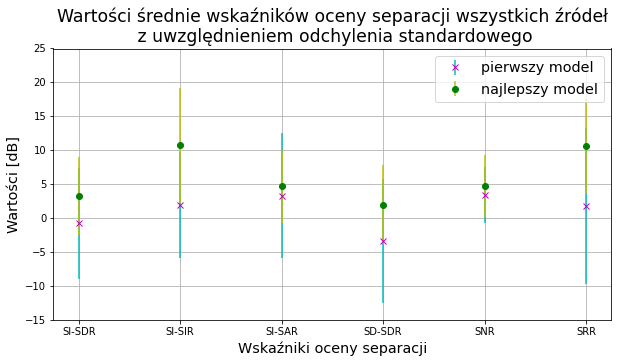

In [36]:

plt.rcParams['figure.figsize'] = [10, 5]

plt.errorbar(reduced_mean_df_old.T['Evaluation'], reduced_mean_df_old.T['OVERALL'].astype(float), yerr=reduced_std_df_old.T['OVERALL'].astype(float), fmt='x', ecolor='c', color='m', label = "pierwszy model")
plt.errorbar(reduced_mean_df.T['Evaluation'], reduced_mean_df.T['OVERALL'].astype(float), yerr=reduced_std_df.T['OVERALL'].astype(float), fmt='o', ecolor='y', color='g', label = "najlepszy model")

plt.title("Wartości średnie wskaźników oceny separacji wszystkich źródeł\n z uwzględnieniem odchylenia standardowego", fontsize='xx-large')
plt.ylabel('Wartości [dB]',  fontsize='x-large')
plt.xlabel('Wskaźniki oceny separacji',  fontsize='x-large')
plt.legend(fontsize='x-large')
plt.ylim([-15, 25])
plt.grid()

plt.savefig(f"/content/models_results_branch/{source}_mean_all.png")
plt.show()

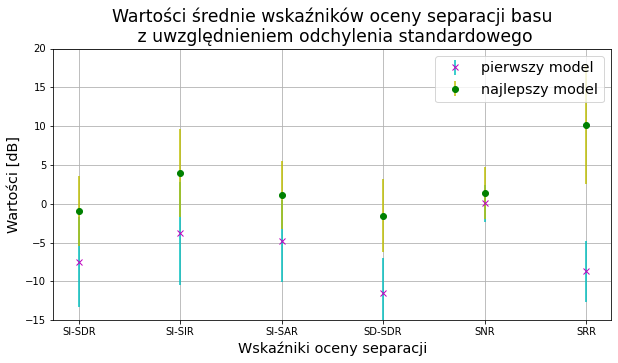

In [37]:
plt.rcParams['figure.figsize'] = [10, 5]

plt.errorbar(reduced_mean_df_old.T['Evaluation'], reduced_mean_df_old.T[source].astype(float), yerr=reduced_std_df_old.T[source].astype(float), fmt='x', ecolor='c', color='m', label = "pierwszy model")
plt.errorbar(reduced_mean_df.T['Evaluation'], reduced_mean_df.T[source].astype(float), yerr=reduced_std_df.T[source].astype(float), fmt='o', ecolor='y', color='g', label = "najlepszy model")

plt.title("Wartości średnie wskaźników oceny separacji basu\n z uwzględnieniem odchylenia standardowego", fontsize='xx-large')
plt.ylabel('Wartości [dB]',  fontsize='x-large')
plt.xlabel('Wskaźniki oceny separacji',  fontsize='x-large')
plt.legend(fontsize='x-large')
plt.ylim([-15, 20])
plt.grid()
plt.savefig(f"/content/models_results_branch/{source}_mean_{source}.png")

plt.show()

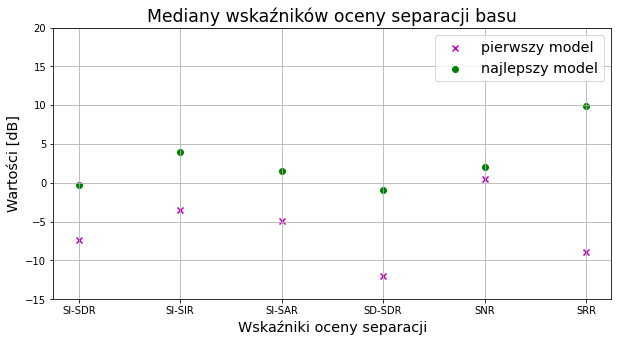

In [40]:
plt.rcParams['figure.figsize'] = [10, 5]

plt.scatter(reduced_median_df_old.T['Evaluation'], reduced_median_df_old.T[source].astype(float), marker='x', color='m', label = "pierwszy model")
plt.scatter(reduced_median_df.T['Evaluation'], reduced_median_df.T[source].astype(float), marker='o', color='g', label = "najlepszy model")

plt.title("Mediany wskaźników oceny separacji basu", fontsize='xx-large')

plt.ylabel('Wartości [dB]',  fontsize='x-large')
plt.xlabel('Wskaźniki oceny separacji',  fontsize='x-large')
plt.legend(fontsize='x-large')
plt.ylim([-15, 20])
plt.grid()
plt.savefig(f"/content/models_results_branch/{source}_median_{source}.png")
plt.show()

## Perkusja

In [41]:
source = "drums"
rest_sources = "drums+vocals+other"


### Stary model

In [ ]:
selected_model_results = [match for match in old_models_results_paths if source in match][0]

df = pd.read_csv(model_dir+selected_model_results)

report, mean_df, std_df, median_df = report_card(
    df, report_each_source=True)

In [43]:
reduced_mean_df_old = pd.DataFrame(mean_df, columns =['Evaluation', 'OVERALL', source, rest_sources]).T 
reduced_mean_df_old = reduced_mean_df_old.drop(reduced_mean_df_old.columns[[0,1,8,9,10,11,12,13]],axis = 1)

reduced_std_df_old = pd.DataFrame(std_df, columns =['Evaluation', 'OVERALL',  source, rest_sources]).T 
reduced_std_df_old = reduced_std_df_old.drop(reduced_std_df_old.columns[[0,1,8,9,10,11,12,13]],axis = 1)

reduced_median_df_old = pd.DataFrame(median_df, columns =['Evaluation', 'OVERALL',  source, rest_sources]).T 
reduced_median_df_old = reduced_median_df_old.drop(reduced_median_df_old.columns[[0,1,8,9,10,11,12,13]],axis = 1)

### Nowy model

In [ ]:
### New models
selected_model_results = [match for match in new_models_results_paths if source in match][0]

df = pd.read_csv(model_dir+selected_model_results)

report, mean_df, std_df, median_df = report_card(
    df, report_each_source=True)

reduced_mean_df = pd.DataFrame(mean_df, columns =['Evaluation', 'OVERALL',  source, rest_sources]).T 
reduced_mean_df = reduced_mean_df.drop(reduced_mean_df.columns[[0,1,8,9,10,11,12,13]],axis = 1)

reduced_std_df = pd.DataFrame(std_df, columns =['Evaluation', 'OVERALL',  source, rest_sources]).T 
reduced_std_df = reduced_std_df.drop(reduced_std_df.columns[[0,1,8,9,10,11,12,13]],axis = 1)

reduced_median_df = pd.DataFrame(median_df, columns =['Evaluation', 'OVERALL',  source, rest_sources]).T 
reduced_median_df = reduced_median_df.drop(reduced_median_df.columns[[0,1,8,9,10,11,12,13]],axis = 1)


In [ ]:
reduced_mean_df.to_excel(f"{source}.xlsx",
             sheet_name='Sheet')  

print(reduced_mean_df.to_latex(index=False))  

### Wykresy

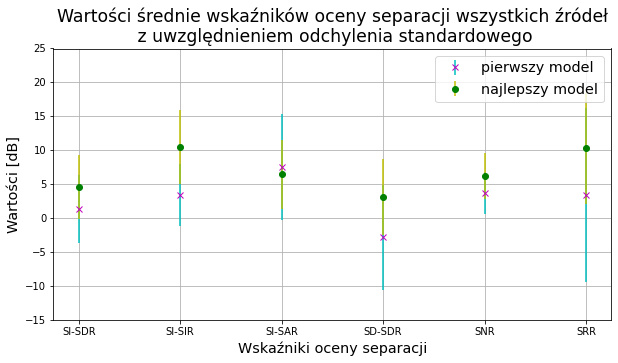

In [46]:

plt.rcParams['figure.figsize'] = [10, 5]

plt.errorbar(reduced_mean_df_old.T['Evaluation'], reduced_mean_df_old.T['OVERALL'].astype(float), yerr=reduced_std_df_old.T['OVERALL'].astype(float), fmt='x', ecolor='c', color='m', label = "pierwszy model")
plt.errorbar(reduced_mean_df.T['Evaluation'], reduced_mean_df.T['OVERALL'].astype(float), yerr=reduced_std_df.T['OVERALL'].astype(float), fmt='o', ecolor='y', color='g', label = "najlepszy model")

plt.title("Wartości średnie wskaźników oceny separacji wszystkich źródeł\n z uwzględnieniem odchylenia standardowego", fontsize='xx-large')
plt.ylabel('Wartości [dB]',  fontsize='x-large')
plt.xlabel('Wskaźniki oceny separacji',  fontsize='x-large')
plt.legend(fontsize='x-large')
plt.ylim([-15, 25])
plt.grid()

plt.savefig(f"/content/models_results_branch/{source}_mean_all.png")
plt.show()

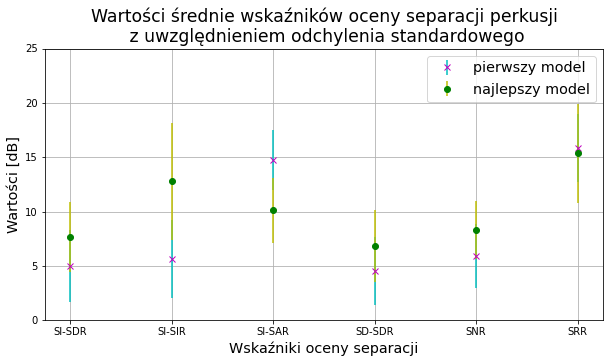

In [51]:
plt.rcParams['figure.figsize'] = [10, 5]

plt.errorbar(reduced_mean_df_old.T['Evaluation'], reduced_mean_df_old.T[source].astype(float), yerr=reduced_std_df_old.T[source].astype(float), fmt='x', ecolor='c', color='m', label = "pierwszy model")
plt.errorbar(reduced_mean_df.T['Evaluation'], reduced_mean_df.T[source].astype(float), yerr=reduced_std_df.T[source].astype(float), fmt='o', ecolor='y', color='g', label = "najlepszy model")

plt.title("Wartości średnie wskaźników oceny separacji perkusji\n z uwzględnieniem odchylenia standardowego", fontsize='xx-large')
plt.ylabel('Wartości [dB]',  fontsize='x-large')
plt.xlabel('Wskaźniki oceny separacji',  fontsize='x-large')
plt.legend(fontsize='x-large')
plt.ylim([0, 25])
plt.grid()
plt.savefig(f"/content/models_results_branch/{source}_mean_{source}.png")

plt.show()

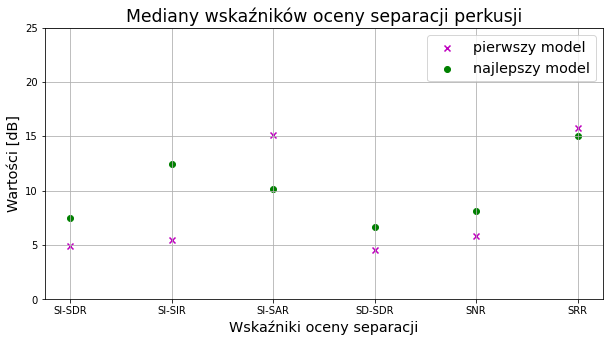

In [52]:
plt.rcParams['figure.figsize'] = [10, 5]

plt.scatter(reduced_median_df_old.T['Evaluation'], reduced_median_df_old.T[source].astype(float), marker='x', color='m', label = "pierwszy model")
plt.scatter(reduced_median_df.T['Evaluation'], reduced_median_df.T[source].astype(float), marker='o', color='g', label = "najlepszy model")

plt.title("Mediany wskaźników oceny separacji perkusji", fontsize='xx-large')

plt.ylabel('Wartości [dB]',  fontsize='x-large')
plt.xlabel('Wskaźniki oceny separacji',  fontsize='x-large')
plt.legend(fontsize='x-large')
plt.ylim([0, 25])
plt.grid()
plt.savefig(f"/content/models_results_branch/{source}_median_{source}.png")
plt.show()

## Wokal

In [53]:
source = "vocals"
rest_sources = "drums+vocals+other"


### Stary model

In [ ]:
selected_model_results = [match for match in old_models_results_paths if source in match][0]

df = pd.read_csv(model_dir+selected_model_results)

report, mean_df, std_df, median_df = report_card(
    df, report_each_source=True)

In [55]:
reduced_mean_df_old = pd.DataFrame(mean_df, columns =['Evaluation', 'OVERALL', source, rest_sources]).T 
reduced_mean_df_old = reduced_mean_df_old.drop(reduced_mean_df_old.columns[[0,1,8,9,10,11,12,13]],axis = 1)

reduced_std_df_old = pd.DataFrame(std_df, columns =['Evaluation', 'OVERALL',  source, rest_sources]).T 
reduced_std_df_old = reduced_std_df_old.drop(reduced_std_df_old.columns[[0,1,8,9,10,11,12,13]],axis = 1)

reduced_median_df_old = pd.DataFrame(median_df, columns =['Evaluation', 'OVERALL',  source, rest_sources]).T 
reduced_median_df_old = reduced_median_df_old.drop(reduced_median_df_old.columns[[0,1,8,9,10,11,12,13]],axis = 1)

### Nowy model

In [ ]:
### New models
selected_model_results = [match for match in new_models_results_paths if source in match][0]

df = pd.read_csv(model_dir+selected_model_results)

report, mean_df, std_df, median_df = report_card(
    df, report_each_source=True)

reduced_mean_df = pd.DataFrame(mean_df, columns =['Evaluation', 'OVERALL',  source, rest_sources]).T 
reduced_mean_df = reduced_mean_df.drop(reduced_mean_df.columns[[0,1,8,9,10,11,12,13]],axis = 1)

reduced_std_df = pd.DataFrame(std_df, columns =['Evaluation', 'OVERALL',  source, rest_sources]).T 
reduced_std_df = reduced_std_df.drop(reduced_std_df.columns[[0,1,8,9,10,11,12,13]],axis = 1)

reduced_median_df = pd.DataFrame(median_df, columns =['Evaluation', 'OVERALL',  source, rest_sources]).T 
reduced_median_df = reduced_median_df.drop(reduced_median_df.columns[[0,1,8,9,10,11,12,13]],axis = 1)


In [ ]:
reduced_mean_df.to_excel(f"{source}.xlsx",
             sheet_name='Sheet')  

print(reduced_mean_df.to_latex(index=False))  

### Wykresy

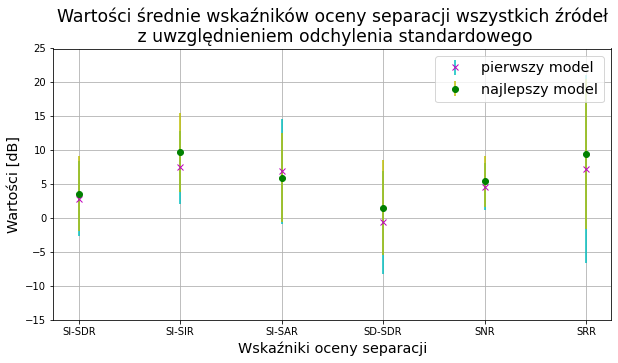

In [58]:

plt.rcParams['figure.figsize'] = [10, 5]

plt.errorbar(reduced_mean_df_old.T['Evaluation'], reduced_mean_df_old.T['OVERALL'].astype(float), yerr=reduced_std_df_old.T['OVERALL'].astype(float), fmt='x', ecolor='c', color='m', label = "pierwszy model")
plt.errorbar(reduced_mean_df.T['Evaluation'], reduced_mean_df.T['OVERALL'].astype(float), yerr=reduced_std_df.T['OVERALL'].astype(float), fmt='o', ecolor='y', color='g', label = "najlepszy model")

plt.title("Wartości średnie wskaźników oceny separacji wszystkich źródeł\n z uwzględnieniem odchylenia standardowego", fontsize='xx-large')
plt.ylabel('Wartości [dB]',  fontsize='x-large')
plt.xlabel('Wskaźniki oceny separacji',  fontsize='x-large')
plt.legend(fontsize='x-large')
plt.ylim([-15, 25])
plt.grid()

plt.savefig(f"/content/models_results_branch/{source}_mean_all.png")
plt.show()

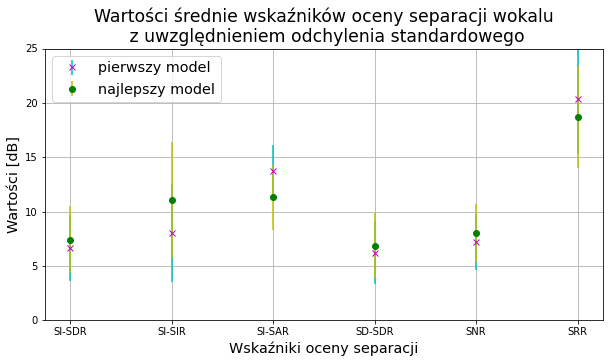

In [61]:
plt.rcParams['figure.figsize'] = [10, 5]

plt.errorbar(reduced_mean_df_old.T['Evaluation'], reduced_mean_df_old.T[source].astype(float), yerr=reduced_std_df_old.T[source].astype(float), fmt='x', ecolor='c', color='m', label = "pierwszy model")
plt.errorbar(reduced_mean_df.T['Evaluation'], reduced_mean_df.T[source].astype(float), yerr=reduced_std_df.T[source].astype(float), fmt='o', ecolor='y', color='g', label = "najlepszy model")

plt.title("Wartości średnie wskaźników oceny separacji wokalu\n z uwzględnieniem odchylenia standardowego", fontsize='xx-large')
plt.ylabel('Wartości [dB]',  fontsize='x-large')
plt.xlabel('Wskaźniki oceny separacji',  fontsize='x-large')
plt.legend(fontsize='x-large')
plt.ylim([0, 25])
plt.grid()
plt.savefig(f"/content/models_results_branch/{source}_mean_{source}.png")

plt.show()

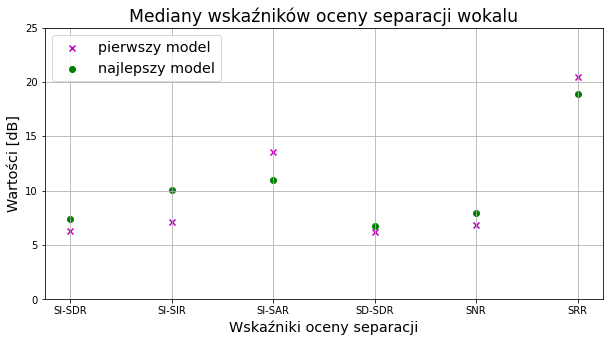

In [62]:
plt.rcParams['figure.figsize'] = [10, 5]

plt.scatter(reduced_median_df_old.T['Evaluation'], reduced_median_df_old.T[source].astype(float), marker='x', color='m', label = "pierwszy model")
plt.scatter(reduced_median_df.T['Evaluation'], reduced_median_df.T[source].astype(float), marker='o', color='g', label = "najlepszy model")

plt.title("Mediany wskaźników oceny separacji wokalu", fontsize='xx-large')

plt.ylabel('Wartości [dB]',  fontsize='x-large')
plt.xlabel('Wskaźniki oceny separacji',  fontsize='x-large')
plt.legend(fontsize='x-large')
plt.ylim([0, 25])
plt.grid()
plt.savefig(f"/content/models_results_branch/{source}_median_{source}.png")
plt.show()



# Pobranie modeli zapisanych w repozytorium

In [63]:
from pathlib import Path
models_branch = Path('/content/models_branch').expanduser()  
models_branch.mkdir(parents=True, exist_ok=True) 

In [64]:
from common import utils
from common.models import MaskInference

In [65]:
!git -C /content/models_branch clone -b models https://github.com/LukaszSzarecki/music-source-separation.git


Cloning into 'music-source-separation'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 77 (delta 15), reused 19 (delta 5), pack-reused 45
Unpacking objects: 100% (77/77), done.
Checking out files: 100% (9/9), done.


Modele na repozytorium:

In [66]:
import os
from pprint import pprint

model_dir = '/content/models_branch/music-source-separation/models/'
new_models_names = os.listdir(model_dir + 'new/')
old_models_names = os.listdir(model_dir + 'old/')

pprint("New trained models")
for m in new_models_names:
  pprint(m)

pprint("Old trained models")
for m in old_models_names:
  pprint(m)

["old/" + model_name for model_name in old_models_names]

old_models_paths = ["old/" + model_name for model_name in old_models_names]
new_models_paths = ["new/" + model_name for model_name in new_models_names]


'New trained models'
'bestbest.model_vocal_11_11_e100_m40.pth'
'bestbest.model_bass_12_11_e100_m40.pth'
'bestbest.model_percussion_10_11_e100_m40.pth'
'Old trained models'
'best.model_vocal_30_10_e10_m25.pth'
'best.model_bass_29_10_e5_m30.pth'
'best.model_percussion_28_10_e5_m15.pth'
'best.model_bass_29_10_e5_m15.pth'


## Wykresy strat przy trenowaniu modelu separującego perkusje

In [77]:
import torch
source = 'percussion'
# source = 'vocal'

selected_new_model = [match for match in new_models_paths if source in match][0]
selected_old_model = [match for match in old_models_paths if source in match][0]
new_model_checkpoint = torch.load(model_dir+selected_new_model)
old_model_checkpoint = torch.load(model_dir+selected_old_model)



In [78]:
new_model_checkpoint['metadata'].keys()

dict_keys(['config', 'nussl_version', 'stft_params', 'sample_rate', 'num_channels', 'train_dataset', 'trainer.state_dict', 'trainer.state.epoch_history'])

In [79]:
new_model_checkpoint['metadata']['trainer.state_dict'].keys() 

dict_keys(['epoch', 'epoch_length', 'max_epochs', 'output', 'metrics', 'seed'])

In [80]:
new_model_checkpoint['metadata']['trainer.state.epoch_history'].keys()

dict_keys(['validation/L1Loss', 'validation/loss', 'train/L1Loss', 'train/loss'])

In [81]:
new_epoch_num = new_model_checkpoint['metadata']['trainer.state_dict']['epoch']
new_train_loss = new_model_checkpoint['metadata']['trainer.state.epoch_history']["train/loss"]

old_epoch_num = old_model_checkpoint['metadata']['trainer.state_dict']['epoch']
old_train_loss = old_model_checkpoint['metadata']['trainer.state.epoch_history']["train/loss"]

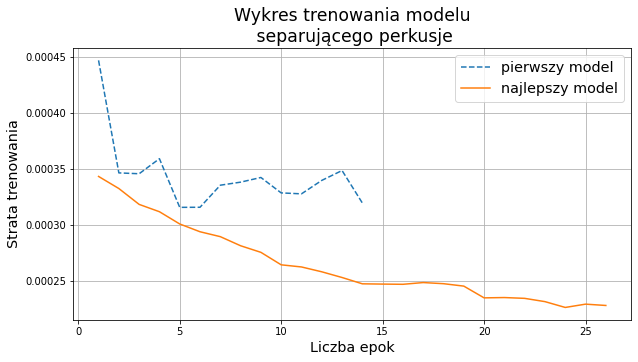

In [82]:
plt.rcParams['figure.figsize'] = [10, 5]

plt.plot(list(range(1,old_epoch_num+1)), old_train_loss, label='pierwszy model',linestyle = '--')
plt.plot(list(range(1,new_epoch_num+1)), new_train_loss, label='najlepszy model')
plt.grid()

plt.title('Wykres trenowania modelu\n separującego perkusje', fontsize='xx-large')
plt.xlabel('Liczba epok', fontsize='x-large')
plt.ylabel('Strata trenowania', fontsize='x-large')
plt.legend(fontsize='x-large')
plt.savefig(f"/content/models_branch/{source}_train_loss.png")
plt.show()

In [83]:
new_val_loss = new_model_checkpoint['metadata']['trainer.state.epoch_history']["validation/loss"]
old_val_loss = old_model_checkpoint['metadata']['trainer.state.epoch_history']["validation/loss"]

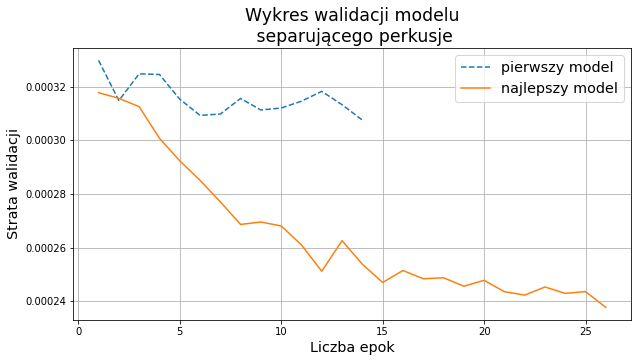

In [84]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(list(range(1,old_epoch_num+1)), old_val_loss, label='pierwszy model',linestyle = '--')
plt.plot(list(range(1,new_epoch_num+1)), new_val_loss, label='najlepszy model')
plt.grid()

plt.title('Wykres walidacji modelu\n separującego perkusje', fontsize='xx-large')
plt.xlabel('Liczba epok', fontsize='x-large')
plt.ylabel('Strata walidacji', fontsize='x-large')
plt.legend(fontsize='x-large')
plt.savefig(f"/content/models_branch/{source}_val_loss.png")
plt.show()


## Wykresy strat przy trenowaniu modelu separującego bas

In [95]:
import torch
# source = 'percussion'
source = 'bas'

selected_new_model = [match for match in new_models_paths if source in match][0]
selected_old_model = [match for match in old_models_paths if source in match][0]
new_model_checkpoint = torch.load(model_dir+selected_new_model)
old_model_checkpoint = torch.load(model_dir+selected_old_model)



In [96]:
new_epoch_num = new_model_checkpoint['metadata']['trainer.state_dict']['epoch']
new_train_loss = new_model_checkpoint['metadata']['trainer.state.epoch_history']["train/loss"]

old_epoch_num = old_model_checkpoint['metadata']['trainer.state_dict']['epoch']
old_train_loss = old_model_checkpoint['metadata']['trainer.state.epoch_history']["train/loss"]

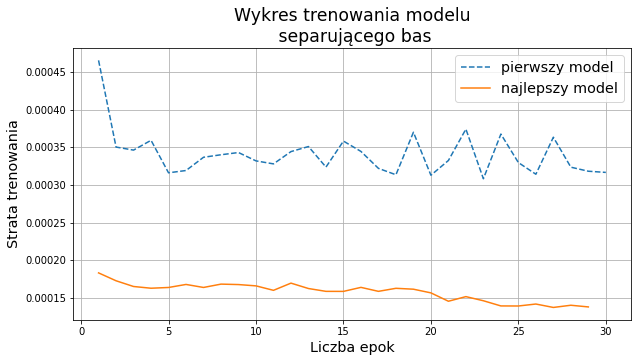

In [97]:
plt.rcParams['figure.figsize'] = [10, 5]

plt.plot(list(range(1,old_epoch_num+1)), old_train_loss, label='pierwszy model',linestyle = '--')
plt.plot(list(range(1,new_epoch_num+1)), new_train_loss, label='najlepszy model')
plt.grid()

plt.title('Wykres trenowania modelu\n separującego bas', fontsize='xx-large')
plt.xlabel('Liczba epok', fontsize='x-large')
plt.ylabel('Strata trenowania', fontsize='x-large')
plt.legend(fontsize='x-large')
plt.savefig(f"/content/models_branch/{source}_train_loss.png")
plt.show()

In [98]:
new_val_loss = new_model_checkpoint['metadata']['trainer.state.epoch_history']["validation/loss"]
old_val_loss = old_model_checkpoint['metadata']['trainer.state.epoch_history']["validation/loss"]

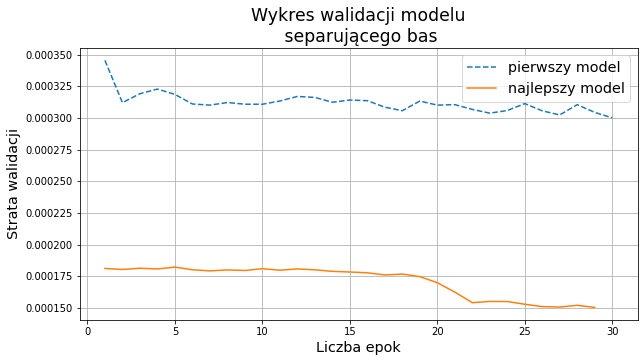

In [99]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(list(range(1,old_epoch_num+1)), old_val_loss, label='pierwszy model',linestyle = '--')
plt.plot(list(range(1,new_epoch_num+1)), new_val_loss, label='najlepszy model')
plt.grid()

plt.title('Wykres walidacji modelu\n separującego bas', fontsize='xx-large')
plt.xlabel('Liczba epok', fontsize='x-large')
plt.ylabel('Strata walidacji', fontsize='x-large')
plt.legend(fontsize='x-large')
plt.savefig(f"/content/models_branch/{source}_val_loss.png")
plt.show()


## Wykresy strat przy trenowaniu modelu separującego wokal

In [90]:
import torch
# source = 'percussion'
source = 'vocal'

selected_new_model = [match for match in new_models_paths if source in match][0]
selected_old_model = [match for match in old_models_paths if source in match][0]
new_model_checkpoint = torch.load(model_dir+selected_new_model)
old_model_checkpoint = torch.load(model_dir+selected_old_model)



In [91]:
new_epoch_num = new_model_checkpoint['metadata']['trainer.state_dict']['epoch']
new_train_loss = new_model_checkpoint['metadata']['trainer.state.epoch_history']["train/loss"]

old_epoch_num = old_model_checkpoint['metadata']['trainer.state_dict']['epoch']
old_train_loss = old_model_checkpoint['metadata']['trainer.state.epoch_history']["train/loss"]

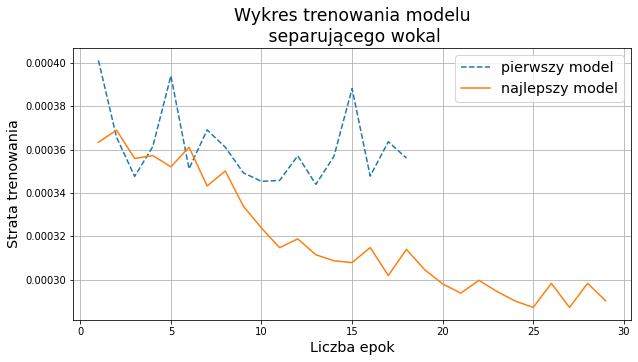

In [92]:
plt.rcParams['figure.figsize'] = [10, 5]

plt.plot(list(range(1,old_epoch_num+1)), old_train_loss, label='pierwszy model',linestyle = '--')
plt.plot(list(range(1,new_epoch_num+1)), new_train_loss, label='najlepszy model')
plt.grid()

plt.title('Wykres trenowania modelu\n separującego wokal', fontsize='xx-large')
plt.xlabel('Liczba epok', fontsize='x-large')
plt.ylabel('Strata trenowania', fontsize='x-large')
plt.legend(fontsize='x-large')
plt.savefig(f"/content/models_branch/{source}_train_loss.png")
plt.show()

In [93]:
new_val_loss = new_model_checkpoint['metadata']['trainer.state.epoch_history']["validation/loss"]
old_val_loss = old_model_checkpoint['metadata']['trainer.state.epoch_history']["validation/loss"]

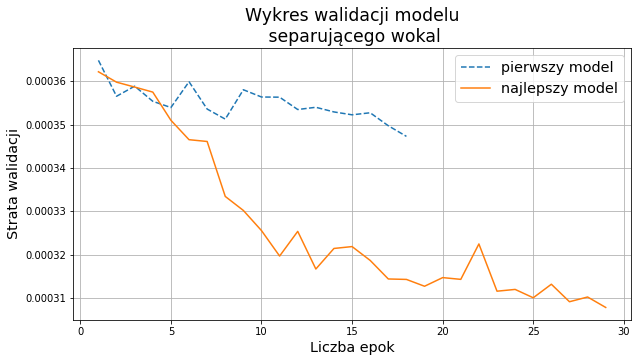

In [94]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(list(range(1,old_epoch_num+1)), old_val_loss, label='pierwszy model',linestyle = '--')
plt.plot(list(range(1,new_epoch_num+1)), new_val_loss, label='najlepszy model')
plt.grid()

plt.title('Wykres walidacji modelu\n separującego wokal', fontsize='xx-large')
plt.xlabel('Liczba epok', fontsize='x-large')
plt.ylabel('Strata walidacji', fontsize='x-large')
plt.legend(fontsize='x-large')
plt.savefig(f"/content/models_branch/{source}_val_loss.png")
plt.show()
